In [1]:
# importação
import pandas as pd
import numpy as np
from sklearn.svm import SVR

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error

## 1. Pegar dados das 3 ações bancárias ITSA4, BBS3, ABCB4 (Neste teste primeiro vamos levar em conta apenas ITSA4)
- Pegando os dados do Yahoo Finance vou iniciar os dados
- Cortei a base de dados dos ultimos 1000 dias
- Coloca como index a data, para usar como série temporal

In [2]:
originalDataset = pd.read_csv('original-data/ITSA4-20140919-20180919.csv')
#originalDataset['Date'] = pd.to_datetime(originalDataset['Date'])
#originalDataset = originalDataset.set_index(['Date'])
originalDataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-19,7.78910,7.84867,7.60294,7.61783,5.761534,21883665
1,2014-09-22,7.43911,7.54336,7.39443,7.54336,5.705210,15211724
2,2014-09-23,7.49124,7.62528,7.38699,7.44656,5.631998,20499939
3,2014-09-24,7.40188,7.52847,7.34231,7.49124,5.665790,10287302
4,2014-09-25,7.42422,7.46890,7.27529,7.27529,5.502464,15131822


# 1.5 Faz o Windowing através do método
- Coloca a função de windowing
- Transforma o dataset em um np.array
- Usa a função de windowing no array
- Transforma o array em um dataset novamente

In [13]:
dataframe = pd.DataFrame(originalDataset.values)

# dataframe[0].shift(5)

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
5      2014-09-19
6      2014-09-22
7      2014-09-23
8      2014-09-24
9      2014-09-25
10     2014-09-26
11     2014-09-29
12     2014-09-30
13     2014-10-01
14     2014-10-02
15     2014-10-03
16     2014-10-06
17     2014-10-07
18     2014-10-08
19     2014-10-09
20     2014-10-10
21     2014-10-13
22     2014-10-14
23     2014-10-15
24     2014-10-16
25     2014-10-17
26     2014-10-20
27     2014-10-21
28     2014-10-22
29     2014-10-23
          ...    
969    2018-07-31
970    2018-08-01
971    2018-08-02
972    2018-08-03
973    2018-08-06
974    2018-08-07
975    2018-08-08
976    2018-08-09
977    2018-08-10
978    2018-08-13
979    2018-08-14
980    2018-08-15
981    2018-08-16
982    2018-08-17
983    2018-08-20
984    2018-08-21
985    2018-08-22
986    2018-08-23
987    2018-08-24
988    2018-08-27
989    2018-08-28
990    2018-08-29
991    2018-08-30
992    2018-08-31
993    201

## 2. Converter o dataset original para a técnica de windowing (5 dias)
- Converter dataset para o preço de **abertura(-7), abertura(-6), fechamento (-7), fechamento (-6), maximo (-7), máximo (-6), minimo (-7), mínimo (-6)**
- Fazer corte de 70% para treino e 30% para teste

In [14]:
# Dataset com todos os valores do atual até -7
originalDataset = pd.read_csv('transformed-data/ITSA4-20140919-20180919-transformed.csv', sep=';')
originalDataset['Date'] = pd.to_datetime(originalDataset['Date'])
originalDataset = originalDataset.set_index(['Date'])
# originalDataset = originalDataset.sample(frac=1)

sizeDataset = 550
trainPercent = 0.7

originalDataset = originalDataset[:sizeDataset]

# Atualiza apenas para valores com -7 e -6
features = ['Open-7','Open-6','High-7','High-6', 'Low-7','Low-6', 'Close-7','Close-6', 'Close-0']
transformedDataset = originalDataset[features]

# Separação dos dados para treinamento e teste 70-30%
lengthDataset = len(transformedDataset)
trainLength = int(lengthDataset * trainPercent)

trainDataset = transformedDataset[:trainLength]
testDataset = transformedDataset[trainLength:lengthDataset]
print(testDataset)

             Open-7   Open-6   High-7   High-6    Low-7    Low-6  Close-7  \
Date                                                                        
2016-04-26  7.16745  7.01146  7.20850  7.11819  6.93757  7.01146  6.96220   
2016-04-27  7.01146  7.01967  7.11819  7.11819  7.01146  6.81441  7.07714   
2016-04-28  7.01967  7.01146  7.11819  7.01146  6.81441  7.01146  7.01967   
2016-04-29  7.01146  6.97041  7.01146  6.97041  7.01146  6.79799  7.01146   
2016-05-02  6.97041  6.78157  6.97041  6.83904  6.79799  6.67484  6.87188   
2016-05-03  6.78157  6.79799  6.83904  6.84725  6.67484  6.69947  6.80620   
2016-05-04  6.79799  6.77336  6.84725  6.97862  6.69947  6.72410  6.73231   
2016-05-05  6.77336  6.97862  6.97862  7.20029  6.72410  6.97041  6.97862   
2016-05-06  6.97862  7.14282  7.20029  7.31523  6.97041  7.04430  7.15103   
2016-05-09  7.14282  7.15924  7.31523  7.21671  7.04430  6.98683  7.13461   
2016-05-10  7.15924  7.15267  7.21671  7.15267  6.98683  6.91786  7.10998   

## 3. Treinar os dados através da SVR
- Usar os dados de entrada para treinar a Support Vector Machine
- Separar dados de entrada e os de saída em duas variáveis

In [15]:
# Separando dados de entrada e de saída
inputFeatures = ['Open-7','Open-6','High-7','High-6', 'Low-7','Low-6', 'Close-7','Close-6']
outputFeatures = ['Close-0']
x_input = trainDataset[inputFeatures]
y_output = trainDataset[outputFeatures].values.ravel()

# Treinando dados de entrada 
svr_rbf = SVR(kernel='rbf', verbose=True)
trainedModel = svr_rbf.fit(x_input, y_output)
print(x_input)
print(y_output)

[LibSVM]             Open-7   Open-6   High-7   High-6    Low-7    Low-6  Close-7  \
Date                                                                        
2014-09-30  7.78910  7.43911  7.84867  7.54336  7.60294  7.39443  7.61783   
2014-10-01  7.43911  7.49124  7.54336  7.62528  7.39443  7.38699  7.54336   
2014-10-02  7.49124  7.40188  7.62528  7.52847  7.38699  7.34231  7.44656   
2014-10-03  7.40188  7.42422  7.52847  7.46890  7.34231  7.27529  7.49124   
2014-10-06  7.42422  7.29763  7.46890  7.61783  7.27529  7.26784  7.27529   
2014-10-07  7.29763  6.98487  7.61783  7.23061  7.26784  6.96998  7.54336   
2014-10-08  6.98487  6.99977  7.23061  7.03700  6.96998  6.73169  7.04444   
2014-10-09  6.99977  6.80615  7.03700  6.82849  6.73169  6.60510  6.90296   
2014-10-10  6.80615  6.73169  6.82849  6.98487  6.60510  6.67956  6.69446   
2014-10-13  6.73169  6.91785  6.98487  7.05189  6.67956  6.86573  6.86573   
2014-10-14  6.91785  7.80399  7.05189  7.95292  6.86573  7.43911  7.

## 4. Comparar dados de teste reais e os preditos
- Pegar os 30% de teste separar em valores de entrada apenas e colocar no modelo
- Colocar os valores preditos em um array
- Colocar os valores reais em outro array
- Colocar os dois em um gráfico

In [16]:
# Separando os dados de entrada e os de saída
x_input_test = testDataset[inputFeatures]
y_original_values = testDataset[outputFeatures].values.ravel()

# Prediz valores do dataset de teste
y_predicted_values = trainedModel.predict(x_input_test)

# Criar um dataset novo com dados originais e os preditos
data = {'date': testDataset.index, 'real': y_original_values, 'predicted': y_predicted_values}
dataFrameCompared = pd.DataFrame(data=data)
x_input_test.head()

mean_squared_error(dataFrameCompared.real, dataFrameCompared.predicted) 

0.088274827961680472

## 5. Plotando gráfico (5 dias a frente)

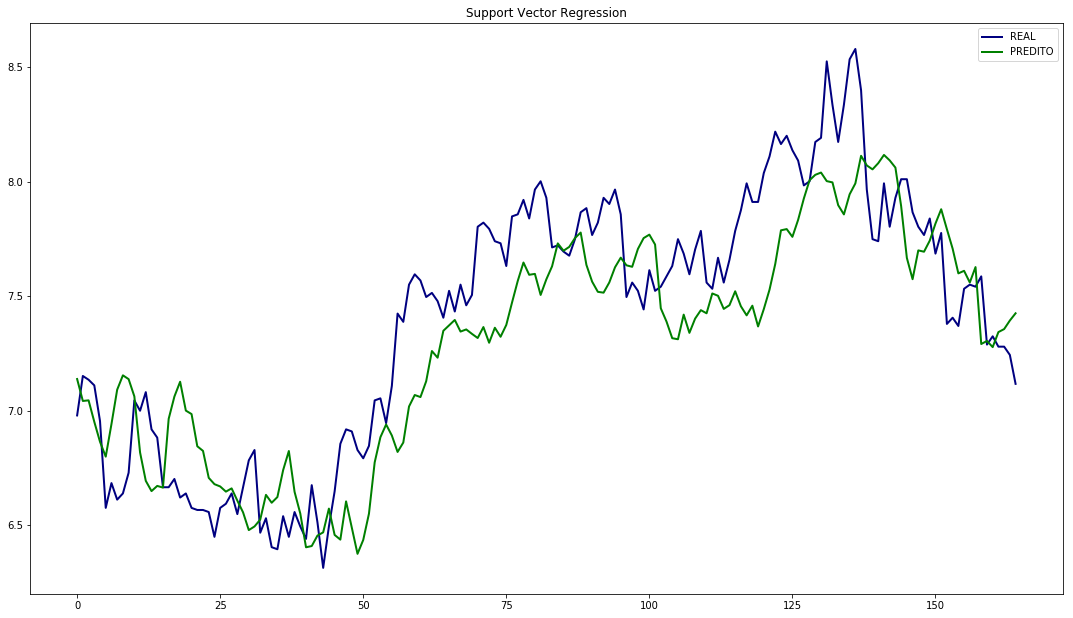

In [17]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)

plt.plot(dataFrameCompared.index, dataFrameCompared.real, color='navy', lw=2, label='REAL')
plt.plot(dataFrameCompared.index, dataFrameCompared.predicted, color='green', lw=2, label='PREDITO')

plt.title('Support Vector Regression')
plt.legend()
plt.show()

## 6. MAPE Mean Square Error

In [49]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print(mean_absolute_percentage_error(dataFrameCompared.real, dataFrameCompared.predicted))

1.2942014321
